Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# CV06 Classification

### Lab Description
This laboratory exercise introduces an **object tracking pipeline** using `YOLOv8`, enabling real-time multi-object tracking on input videos.
Rather than training a new model, we directly apply a pretrained YOLOv8 detector along with a tracker (e.g., ByteTrack) to detect objects and assign unique identities across frames.

The workflow includes:
- Loading a pretrained YOLOv8 detector
- Performing object detection + data association (tracking)
- Exporting tracked video with bounding boxes and object IDs
- Visualizing the first and last frames of the output video for quick inspection

This lab emphasizes how modern tracking pipelines integrate object detection with lightweight tracking modules to maintain consistent identities throughout a video sequence.

### What you can expect to learn
- **Core Concepts**
    - Understand how object detection is combined with tracking to perform Multi-Object Tracking (MOT).
    - Learn ByteTrack’s role in associating detections across video frames.

- **YOLOv8 Tracking Pipeline**
    - Load pretrained YOLOv8 models for detection and tracking.
    - Configure inference settings such as confidence threshold, IoU threshold, and input resizing.
    - Export tracking results including bounding boxes and persistent object IDs.

- **Execution & Result Handling**
    - Run inference on custom videos.
    - Save outputs to structured directories.
    - Automatically locate and preview tracked results.

- **Visualization & Evaluation**
    - Display the first and last tracked frames using Matplotlib.
    - Visually validate model performance and identity consistency.

This lab demonstrates how to build an end-to-end tracking workflow without needing dataset preparation or model training, making it ideal for rapid prototyping in video analytics and surveillance applications.


In [1]:
import sys, torch, torchvision
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Python: 3.10.19
PyTorch: 2.10.0.dev20251101+rocm7.0
Torchvision: 0.25.0.dev20251102+rocm7.0
CUDA available: True
CUDA device: AMD Radeon AI PRO R9700


## 1. Import necessary libraries

In [2]:
!pip install moviepy
!pip install -q ultralytics

In [3]:
import os
import cv2
import time
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Video, display
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/aup/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Setting
Configure the computation device and specify the input/output video paths.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [7]:
# Input video path
VIDEO_PATH = "video.mp4" # your target video
assert VIDEO_PATH, "Please upload your video"
assert Path(VIDEO_PATH).exists(), f"Cannot found：{VIDEO_PATH}"

# Tracking results path
OUTPUT_DIR = os.path.expanduser("~/data/tracking")
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_VIDEO_PATH = str(Path(OUTPUT_DIR) / "output.mp4") 

## 3. Model: YOLOv8
We load a pretrained `YOLOv8` object detector and apply multi-object tracking directly on the input video.
The tracker used here is `ByteTrack`, which associates detections across frames to assign consistent IDs.

In [8]:
model = YOLO("yolov8n.pt") 
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

## 4. Tracking
We apply multi-object tracking on the given video using the Ultralytics high-level `model.track()` API:
- Tracker uses **ByteTrack** (`bytetrack.yaml`) for data association.
- We enable:
  - `save=True` → Save the output video with rendered boxes & IDs.
  - `persist=True` → Maintain consistent identity across frames.
  - `project` & `name` → Control output directory.
- After tracking finishes, we automatically locate the rendered video file so it can be displayed or further processed.
- The returned `track_res` object contains per-frame detection/track results, including:
  - bounding boxes
  - tracking IDs
  - class labels
  - confidence scores

In [11]:
track_res = model.track(
    source=VIDEO_PATH,
    tracker="bytetrack.yaml",   
    device=device,
    save=True,                  
    project=OUTPUT_DIR,
    name="exp",
    exist_ok=True,
    persist=True,               
    verbose=False
)
print("Tracking done.")

def find_output_video(run_dir: Path) -> str:
    vids = list(run_dir.glob("*.mp4")) + list(run_dir.glob("*.avi")) + list(run_dir.glob("*.mov")) + list(run_dir.glob("*.mkv"))
    if vids:
        return str(vids[0])
    for p in run_dir.rglob("*"):
        if p.suffix.lower() in [".mp4", ".avi", ".mov", ".mkv"]:
            return str(p)
    return ""

RUN_DIR = Path(OUTPUT_DIR) / "exp"
OUTPUT_VIDEO_PATH = find_output_video(RUN_DIR)
print("OUTPUT_VIDEO_PATH:", OUTPUT_VIDEO_PATH)

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /home/aup/data/tracking/exp
Tracking done.
OUTPUT_VIDEO_PATH: /home/aup/data/tracking/exp/video.avi


## 5. Visualization
We extract frames from the tracked output video to provide a quick qualitative check of the tracking results.
Specifically, we display:
* The **first frame**
* The **last frame**

This allows us to verify if objects are properly detected and tracked across the entire sequence.

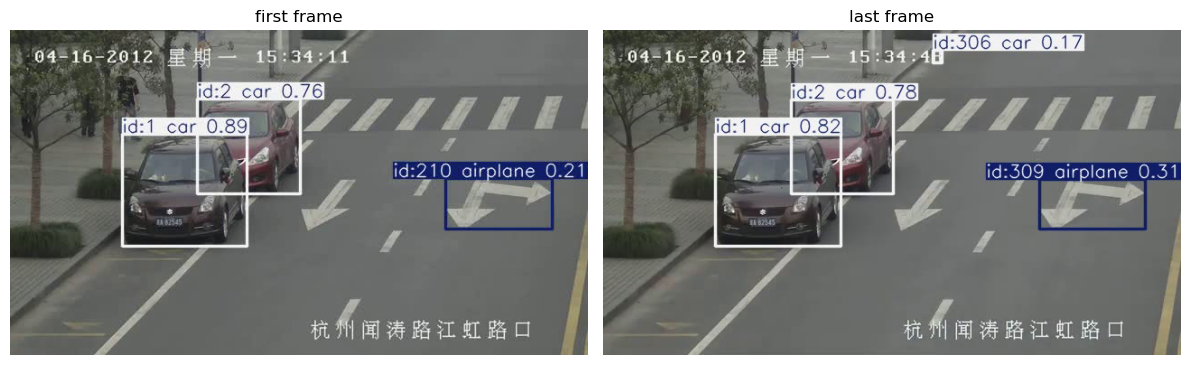

In [12]:
assert OUTPUT_VIDEO_PATH and Path(OUTPUT_VIDEO_PATH).exists(), "OUTPUT_VIDEO_PATH not set or file not found."

cap = cv2.VideoCapture(OUTPUT_VIDEO_PATH)
if not cap.isOpened():
    print("Cannot open video.")
else:
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ok1, first_frame = cap.read()

    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, total_frames - 1))
    ok2, last_frame = cap.read()
    cap.release()

    if ok1 and ok2:
        first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
        last_frame = cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.imshow(first_frame); plt.title("first frame"); plt.axis("off")
        plt.subplot(1, 2, 2); plt.imshow(last_frame); plt.title("last frame"); plt.axis("off")
        plt.tight_layout(); plt.show()
    else:
        print("Cannot read frames.")